In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [11]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

# 分類数設定

In [12]:
NUM_CLASSES = 12

# 入力長

In [13]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [14]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [15]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [18]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [19]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,174 (4.59 KB)

 Trainable params: 1,174 (4.59 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True  # Helps debug by disabling graph mode
)

# モデル訓練

In [24]:
try:
    history = model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=10,  # Start with fewer epochs
        batch_size=32,  # Reduced from 128
        validation_data=(X_test.astype(np.float32), y_test),
        callbacks=[cp_callback, es_callback],
        verbose=1
    )
except Exception as e:
    print("Detailed error:", str(e))
    raise

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1244 - loss: 2.3856
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.1247 - loss: 2.3847 - val_accuracy: 0.2036 - val_loss: 1.8777
Epoch 2/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2500 - loss: 1.8151
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2504 - loss: 1.8141 - val_accuracy: 0.3363 - val_loss: 1.5491
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3494 - loss: 1.5565
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3495 - loss: 1.5563 - val_accuracy: 0.4423 - val_loss: 1.4130
Epoch 4/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4175 - loss: 1.4687
Epoch 4: saving model to model/point_

Epoch 157/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.4322 - accuracy: 0.8384
Epoch 00157: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4319 - accuracy: 0.8404 - val_loss: 0.2081 - val_accuracy: 0.9615
Epoch 158/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.4179 - accuracy: 0.8522
Epoch 00158: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4218 - accuracy: 0.8482 - val_loss: 0.2074 - val_accuracy: 0.9622
Epoch 159/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.4368 - accuracy: 0.8450
Epoch 00159: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4420 - accuracy: 0.8426 - val_loss: 0.2090 - val_accuracy: 0.9637
Epoch 160/1000
26/32 [=======================>

Epoch 183/1000
26/32 [=======================>......] - ETA: 0s - loss: 0.4351 - accuracy: 0.8459
Epoch 00183: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 0.4335 - accuracy: 0.8482 - val_loss: 0.1944 - val_accuracy: 0.9645
Epoch 184/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.4186 - accuracy: 0.8422
Epoch 00184: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4222 - accuracy: 0.8454 - val_loss: 0.1945 - val_accuracy: 0.9645
Epoch 185/1000
32/32 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8459
Epoch 00185: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4106 - accuracy: 0.8459 - val_loss: 0.1939 - val_accuracy: 0.9660
Epoch 186/1000
25/32 [======================>.

Epoch 209/1000
26/32 [=======================>......] - ETA: 0s - loss: 0.4140 - accuracy: 0.8407
Epoch 00209: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4080 - accuracy: 0.8444 - val_loss: 0.1874 - val_accuracy: 0.9645
Epoch 210/1000
32/32 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8567
Epoch 00210: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4091 - accuracy: 0.8567 - val_loss: 0.1879 - val_accuracy: 0.9683
Epoch 211/1000
28/32 [=========================>....] - ETA: 0s - loss: 0.4135 - accuracy: 0.8418
Epoch 00211: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 0.4142 - accuracy: 0.8429 - val_loss: 0.1873 - val_accuracy: 0.9675
Epoch 212/1000
25/32 [======================>.

Epoch 235/1000
32/32 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8610
Epoch 00235: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3989 - accuracy: 0.8610 - val_loss: 0.1768 - val_accuracy: 0.9705
Epoch 236/1000
27/32 [========================>.....] - ETA: 0s - loss: 0.4107 - accuracy: 0.8539
Epoch 00236: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 0.4055 - accuracy: 0.8540 - val_loss: 0.1794 - val_accuracy: 0.9668
Epoch 237/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3972 - accuracy: 0.8484
Epoch 00237: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4037 - accuracy: 0.8474 - val_loss: 0.1788 - val_accuracy: 0.9683
Epoch 238/1000
26/32 [=======================>

Epoch 261/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3938 - accuracy: 0.8637
Epoch 00261: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.4018 - accuracy: 0.8595 - val_loss: 0.1723 - val_accuracy: 0.9683
Epoch 262/1000
26/32 [=======================>......] - ETA: 0s - loss: 0.3979 - accuracy: 0.8621
Epoch 00262: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 0.3969 - accuracy: 0.8610 - val_loss: 0.1716 - val_accuracy: 0.9660
Epoch 263/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3927 - accuracy: 0.8541
Epoch 00263: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3899 - accuracy: 0.8552 - val_loss: 0.1736 - val_accuracy: 0.9683
Epoch 264/1000
25/32 [======================>.

Epoch 287/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3942 - accuracy: 0.8609
Epoch 00287: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3916 - accuracy: 0.8605 - val_loss: 0.1672 - val_accuracy: 0.9675
Epoch 288/1000
28/32 [=========================>....] - ETA: 0s - loss: 0.3862 - accuracy: 0.8577
Epoch 00288: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 0.3879 - accuracy: 0.8593 - val_loss: 0.1700 - val_accuracy: 0.9690
Epoch 289/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3733 - accuracy: 0.8625
Epoch 00289: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3798 - accuracy: 0.8608 - val_loss: 0.1680 - val_accuracy: 0.9698
Epoch 290/1000
25/32 [======================>.

Epoch 313/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3702 - accuracy: 0.8725
Epoch 00313: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3745 - accuracy: 0.8673 - val_loss: 0.1671 - val_accuracy: 0.9690
Epoch 314/1000
26/32 [=======================>......] - ETA: 0s - loss: 0.3874 - accuracy: 0.8639
Epoch 00314: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3850 - accuracy: 0.8658 - val_loss: 0.1636 - val_accuracy: 0.9705
Epoch 315/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3865 - accuracy: 0.8628
Epoch 00315: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3923 - accuracy: 0.8603 - val_loss: 0.1645 - val_accuracy: 0.9705
Epoch 316/1000
27/32 [========================

Epoch 339/1000
32/32 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8633
Epoch 00339: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3769 - accuracy: 0.8633 - val_loss: 0.1553 - val_accuracy: 0.9683
Epoch 340/1000
25/32 [======================>.......] - ETA: 0s - loss: 0.3625 - accuracy: 0.8669
Epoch 00340: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3648 - accuracy: 0.8653 - val_loss: 0.1565 - val_accuracy: 0.9698
Epoch 341/1000
26/32 [=======================>......] - ETA: 0s - loss: 0.3605 - accuracy: 0.8669
Epoch 00341: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 11ms/step - loss: 0.3588 - accuracy: 0.8688 - val_loss: 0.1580 - val_accuracy: 0.9675
Epoch 342/1000
25/32 [======================>.

In [25]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [26]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[5.6668299e-01 1.5199320e-01 1.3488965e-01 9.4334111e-02 8.1456856e-05
 4.1695850e-05 2.1414463e-04 6.1710271e-05 1.8185798e-02 3.3386439e-02
 2.5090876e-05 1.0374154e-04]
0


# 混同行列

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


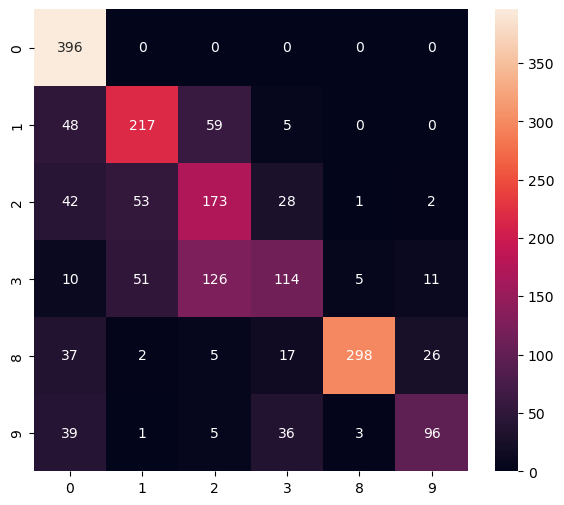

Classification Report
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       396
           1       0.67      0.66      0.66       329
           2       0.47      0.58      0.52       299
           3       0.57      0.36      0.44       317
           8       0.97      0.77      0.86       385
           9       0.71      0.53      0.61       180

    accuracy                           0.68      1906
   macro avg       0.68      0.65      0.65      1906
weighted avg       0.69      0.68      0.67      1906



In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [28]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [29]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [31]:
try:
    # Create a concrete function for conversion
    run_model = tf.function(lambda x: model(x))
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([1, *X_train.shape[1:]], dtype=tf.float32))
    
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quantized_model = converter.convert()
    
    # Save the quantized model
    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_quantized_model)
    print("TFLite conversion successful!")
    
except Exception as e:
    print(f"Conversion failed: {str(e)}")
    # Fallback to SavedModel approach if needed
    try:
        model.save('temp_savedmodel', save_format='tf')
        converter = tf.lite.TFLiteConverter.from_saved_model('temp_savedmodel')
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_quantized_model = converter.convert()
        with open(tflite_save_path, 'wb') as f:
            f.write(tflite_quantized_model)
        print("Used SavedModel fallback successfully!")
    except Exception as e2:
        print(f"Fallback also failed: {str(e2)}")
        raise

TFLite conversion successful!


# 推論テスト

In [32]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [33]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'x', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([ 1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [34]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [35]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [36]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.6668293e-01 1.5199322e-01 1.3488966e-01 9.4334126e-02 8.1456848e-05
 4.1695883e-05 2.1414472e-04 6.1710263e-05 1.8185804e-02 3.3386443e-02
 2.5090849e-05 1.0374153e-04]
0
